# Analysis

In [8]:
import matplotlib.pyplot as plt
import yt
from rich import print
import panel as pn
from loguru import logger

import logging
import json
from yt.data_objects.time_series import SimulationTimeSeries
from yt.data_objects.static_output import Dataset

In [9]:
import os
from pathlib import Path

dim = 1
dim = 2
dim = 3
beta = 0.25
theta = 60

try:
    base_dir = Path(os.getcwd()) / "01_oblique_linear_alfven"
    sub_dir = f"dim_{dim}_beta_{beta}_theta_{theta}"
    directory = base_dir / sub_dir
    os.chdir(directory)
except FileNotFoundError:
    pass

In [10]:
pn.extension()

# load simulation parameters
with open("sim_parameters.json", "rb") as f:
    meta = json.load(f)

ytLogger = logging.getLogger("yt")
ytLogger.setLevel(logging.WARNING)

## Energy evolution in the system with your input parameters

2024-04-25 13:55:07.330 | INFO     | __main__:read_diag_file:14 - Index(['#[0]step()', '[1]time(s)', '[2]total_lev0(J)', '[3]E_lev0(J)',
       '[4]B_lev0(J)'],
      dtype='object')
2024-04-25 13:55:07.332 | INFO     | __main__:read_diag_file:14 - Index(['#[0]step()', '[1]time(s)', '[2]total(J)', '[3]ions(J)',
       '[4]total_mean(J)', '[5]ions_mean(J)'],
      dtype='object')


Index(['step', 'time', 'E_field', 'E_lev0', 'B_lev0', 'time_norm', 'E_part',
       'ions', 'total_mean', 'ions_mean', 'E_total'],
      dtype='object')

<Axes: xlabel='time ($T_{ci}$)', ylabel='Energy ($J$)'>

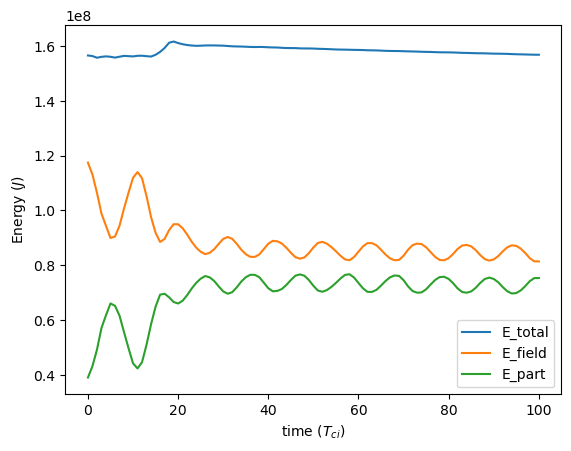

In [11]:
import pandas as pd

def read_diag_file(path, rename_func=lambda x: x.split("]")[1].split("(")[0]):
    """
    read the diagnostic file as a dataframe from the path
    
    file format is like this:
    ```
    step time ...
    0 0.0 ...
    ```
    """
    df = pd.read_csv(path, sep=" ")
    logger.info(df.columns)
    # rename the columns from something like '[2]total(J)' to 'total'
    new_df = df.rename(columns=rename_func).assign(time_norm=lambda x: x.time / meta["t_ci"])
    return new_df

def plot_energy_evolution(
    field_energy_diag_path = "diags/reducedfiles/field_energy.txt",
    part_energy_diag_path = "diags/reducedfiles/part_energy.txt"
):
    field_energy = read_diag_file(field_energy_diag_path).rename(columns={"total_lev0": "E_field"})
    part_energy = read_diag_file(part_energy_diag_path).rename(columns={"total": "E_part"})
    energy_df = field_energy.merge(part_energy).assign(E_total=lambda x: x.E_field + x.E_part)
    print(energy_df.columns)
    
    ax = energy_df.plot(x="time_norm", y=["E_total", "E_field", "E_part"])
    ax.set_xlabel(r"time ($T_{ci}$)")
    ax.set_ylabel(r"Energy ($J$)")    
    return ax

plot_energy_evolution()

## Fields

In [40]:
diag_format = meta['diag_format']

if diag_format == "openpmd":
    ext = meta['diag_openpmd_backend']
    file_format = f"/{diag_format}*.{ext}"
else:
    file_format = "??????"

In [175]:
field_diag_dir = "diags/diag1"
ts_field: SimulationTimeSeries = yt.load(f"{field_diag_dir}{file_format}")
ds_field = ts_field[0]
# ts = yt.load('./diags/diag???0032')

In [14]:
def ds2df(ds: Dataset) -> pd.DataFrame:
    fields = ds.field_list
    coords = ["x", "y", "z"]
    return ds.all_data().to_dataframe(fields + coords).assign(time = ds.current_time)

def export_ds(ds: Dataset):
    # new_fn = ds.filename(ext, "arrow")
    new_fn = ds.filename + ".arrow"
    df = ds2df(ds)
    df.to_feather(new_fn)
    return new_fn

def export_ts(ts: SimulationTimeSeries):
    return [export_ds(ds) for ds in ts.piter()]

def test_export():
    df = ds2df(ds)
    logger.debug(df.columns)
    
    logger.debug(export_ds(ds))

In [38]:
export_ts(ts)

['/Users/zijin/projects/swd_simulation/warpx/01_oblique_linear_alfven/dim_3_beta_0.25_theta_60/diags/diag1000000.arrow',
 '/Users/zijin/projects/swd_simulation/warpx/01_oblique_linear_alfven/dim_3_beta_0.25_theta_60/diags/diag1000100.arrow',
 '/Users/zijin/projects/swd_simulation/warpx/01_oblique_linear_alfven/dim_3_beta_0.25_theta_60/diags/diag1000200.arrow',
 '/Users/zijin/projects/swd_simulation/warpx/01_oblique_linear_alfven/dim_3_beta_0.25_theta_60/diags/diag1000300.arrow',
 '/Users/zijin/projects/swd_simulation/warpx/01_oblique_linear_alfven/dim_3_beta_0.25_theta_60/diags/diag1000400.arrow',
 '/Users/zijin/projects/swd_simulation/warpx/01_oblique_linear_alfven/dim_3_beta_0.25_theta_60/diags/diag1000500.arrow',
 '/Users/zijin/projects/swd_simulation/warpx/01_oblique_linear_alfven/dim_3_beta_0.25_theta_60/diags/diag1000600.arrow',
 '/Users/zijin/projects/swd_simulation/warpx/01_oblique_linear_alfven/dim_3_beta_0.25_theta_60/diags/diag1000700.arrow',
 '/Users/zijin/projects/swd_simu

## Particles

In [174]:
part_diag_dir = "diags/diag2"

ts_part : SimulationTimeSeries = yt.load(f"{part_diag_dir}{file_format}")
ds_part = ts_part[0]


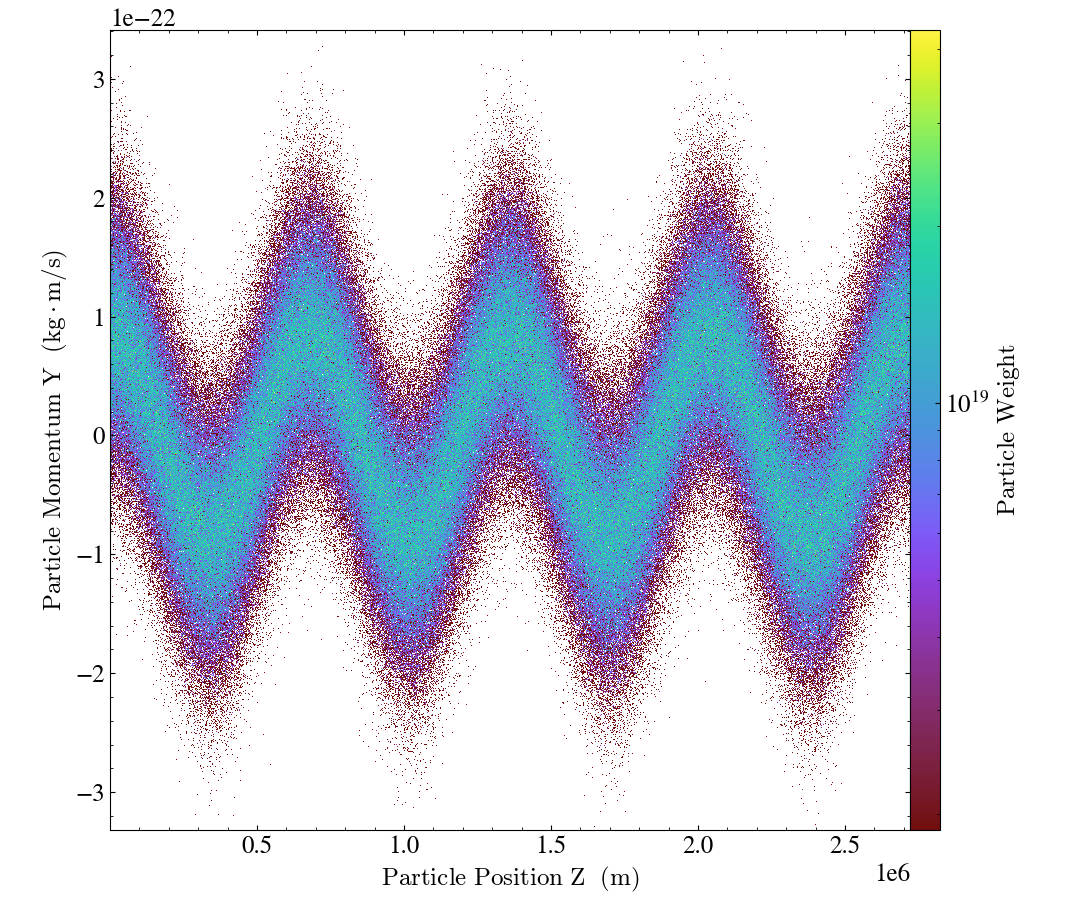

In [70]:
direction = "z"
ps = "ions"
# slc = yt.SlicePlot(ds, direction, fields, origin="native")

x_field = f"particle_position_{direction}"
y_field = "particle_momentum_y"

p = yt.ParticlePlot(
    ds,
    x_field,
    y_field,
    (ps, "particle_weight"),
)
p.set_log(y_field, False)

In [104]:
field = ds_field.fields.boxlib.By
field.take_log = False

In [213]:
from functools import partial

plot_field = partial(
    yt.ProfilePlot,
    x_field=direction,
    weight_field=("boxlib", "volume"),
    x_log=False,
    y_log=False,
    n_bins=meta[f"n{direction}"]
)

# yt.create_profile()
plot_particle_profile = partial(
    yt.ProfilePlot,
    x_field=f"particle_position_{direction}",
    weight_field=(ps, "particle_weight"),
    x_log=False,
    y_log=False
)

In [211]:
def plot_field_with_plasma_profile(ds_field, ds_part):
    
    p0 = plot_field(ds_field, y_fields="By", n_bins=256)
    p1 = plot_particle_profile(ds_part, y_fields="particle_momentum_y", n_bins=128)
    
    # Customizing the plot
    fig, ax = plt.subplots()
    ax2 = ax.twinx()

    plot = p0.plots[("By")]
    plot.figure = fig
    plot.axes = ax

    plot = p1.plots[("particle_momentum_y")]
    plot.figure = fig
    plot.axes = ax2

    p0.render()
    p1.render()

    ax2.yaxis.set_label_position("right")
    ax2.yaxis.set_offset_position("right")
    # set the color of the labels and lines
    ax2.yaxis.label.set_color("orange")
    ax2.lines[0].set_color("orange")
    fig.set_size_inches(12, 5)
    return fig

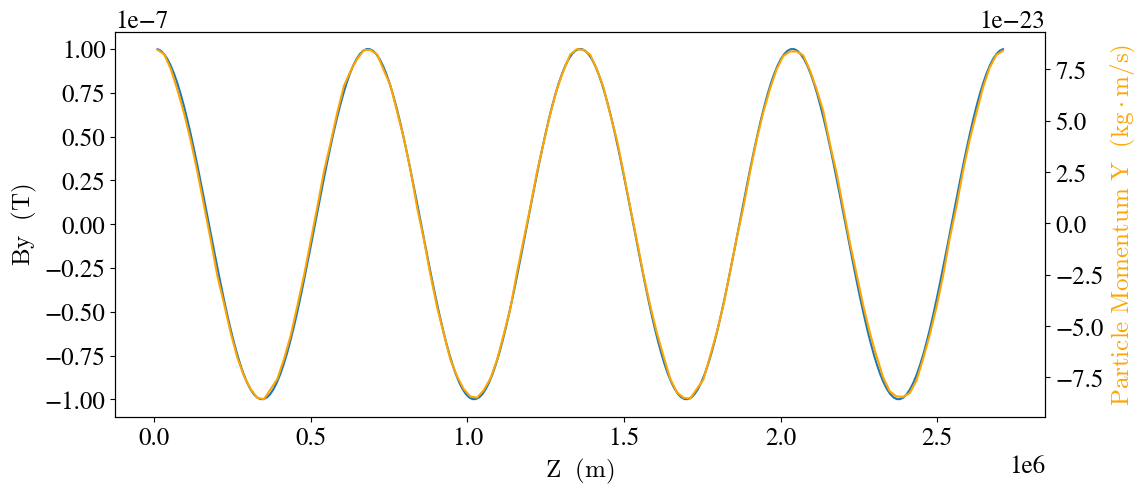

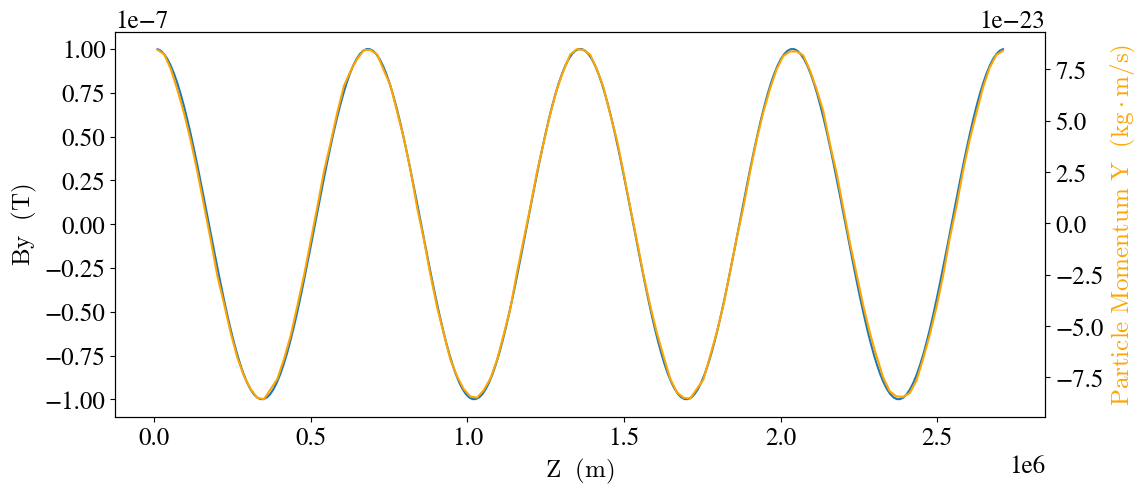

In [212]:
plot_field_with_plasma_profile(ds_field, ds_part)

In [128]:
for ds_field, ds_part in zip(ts_field, ts_part):
    fig = plot_field_with_plasma_profile(ds_field, ds_part)
    

### yt

In [6]:
ts: SimulationTimeSeries = yt.load('diags/diag1??????')
# ts = yt.load('./diags/diag???0032')

FileNotFoundError: No match found for pattern : diags/diag1??????

In [ ]:
def plot(ds, normalize = True, **kwargs):
    ad = ds.all_data()
    fields = ["Bx", "By", "Bz"]

    match meta["dim"]:
        case 1: pos = "x"
        case 2: pos = "y"
        
    pos = ad[pos]
    
    if normalize:
        pos = pos / meta['d_i']
    
    for field in fields:
        plt.plot(pos, ad[field], label=field, **kwargs)
    
    plt.xlabel("x ($d_i$)")
        
def hodogram(ds, comp1="By", comp2="Bz"):
    time = ds.current_time
    time_norm = time.value / meta['t_ci']
    ad = ds.all_data()
    plt.plot(ad[comp1], ad[comp2], label=f"t={time_norm:.2f}")
    plt.xlabel(comp1)
    plt.ylabel(comp2)

In [ ]:
for i, ds in enumerate(ts):
    alpha = (i + 1) / (len(ts)+1)
    plot(ds, alpha=alpha)
    plt.show()  # Show each plot separately

In [ ]:
i = 4
_ts = ts[0:i]
for i, ds in enumerate(_ts):
    alpha = (i + 1) / (len(_ts)+1)
    plot(ds, alpha=alpha)
    plt.show()  # Show each plot separately

In [ ]:
for ds in ts:
    hodogram(ds)
    plt.legend()

In [ ]:
i = 5
for ds in ts[0:i]:
    hodogram(ds)
    plt.legend()

In [ ]:
yt.SlicePlot(ds, "z", ("boxlib", "Bz"))

In [124]:
ds.all_data()

YTRegion (openpmd_000000.h5): , center=[1360407.874965       0.             0.      ] m, left_edge=[     0.         -42512.74609266 -42512.74609266] m, right_edge=[2720815.74993      42512.74609266   42512.74609266] m

In [119]:
fields = [
    ("Bx"),
    ("By"),
    ("Bz"),
    ("mesh", "magnetic_field_strength"),
]

In [120]:
for ds in ts.piter():
    p = yt.plot_2d(ds, fields=fields)
    p.set_log(fields, False)
    fig = p.export_to_mpl_figure((2, 2))
    fig.tight_layout()
    fig.savefig(f"figures/{ds}_magnetic_field.png")

RuntimeError: plot_2d only plots 2D datasets!

### Average magnetic field

In [22]:
def plot_avg(ds):
    fields = [
        ("Bx"),
        ("By"),
        ("Bz"),
    ]

    ad = ds.all_data()
    df = ad.to_dataframe(fields + ["x", zaxis])
    # compute the magnetic field strength
    df = df.assign(B=lambda x: (x.Bx**2 + x.By**2 + x.Bz**2) ** 0.5)

    axes = df.groupby(zaxis).mean().plot(y=fields + ["B"], subplots=True)
    return axes[0].figure

BokehModel(combine_events=True, render_bundle={'docs_json': {'b2794ddf-cb6a-494d-a3a1-782bd542339e': {'version…

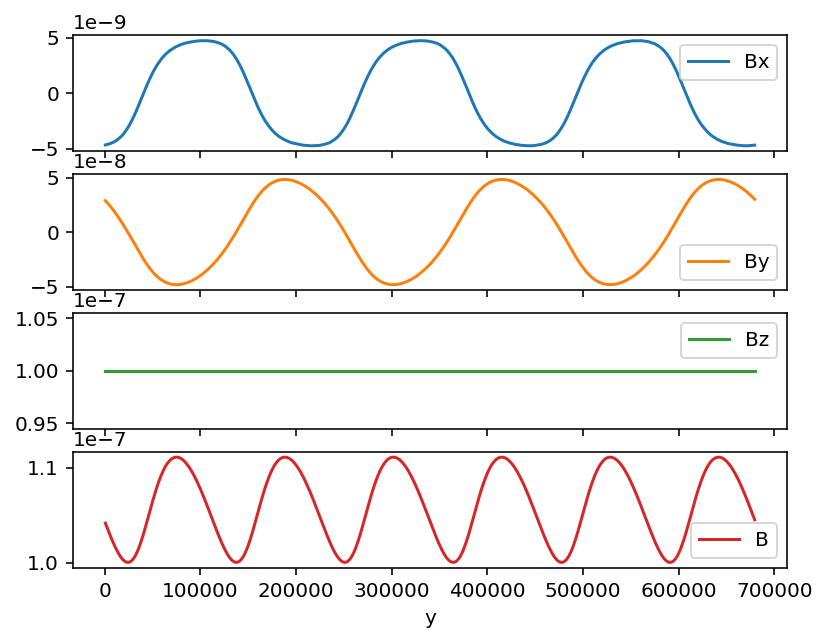

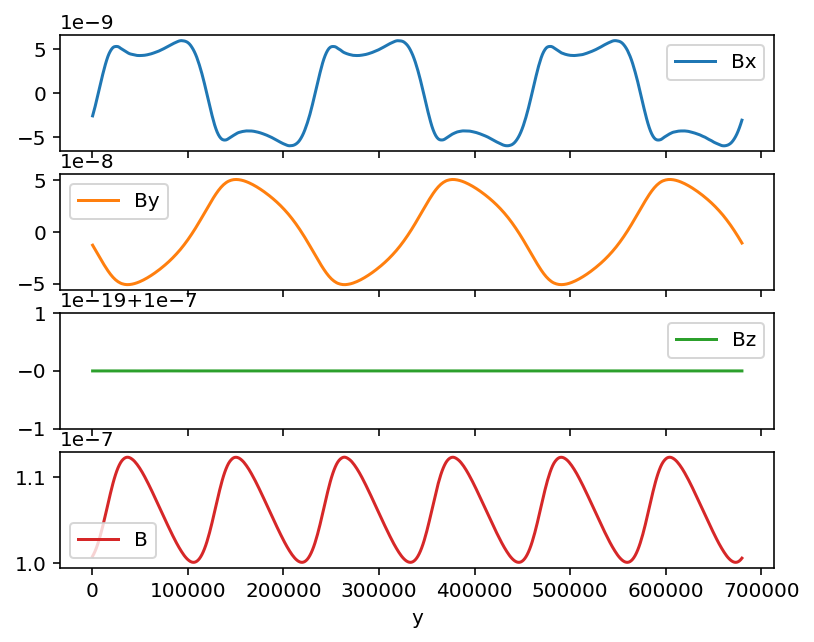

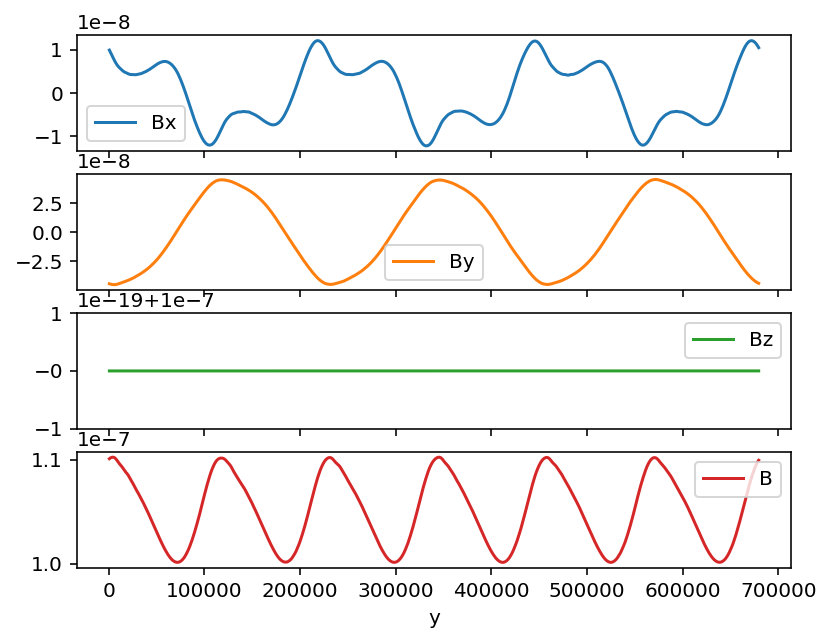

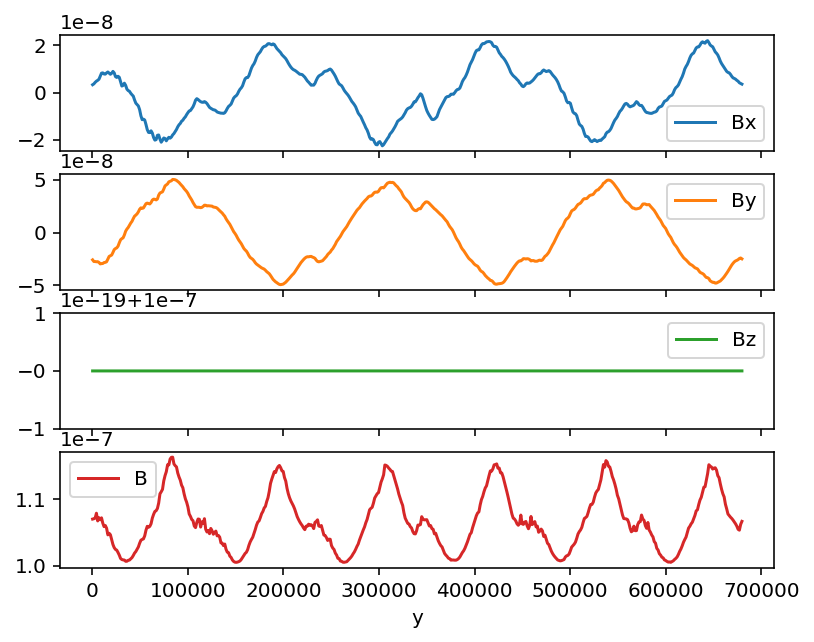

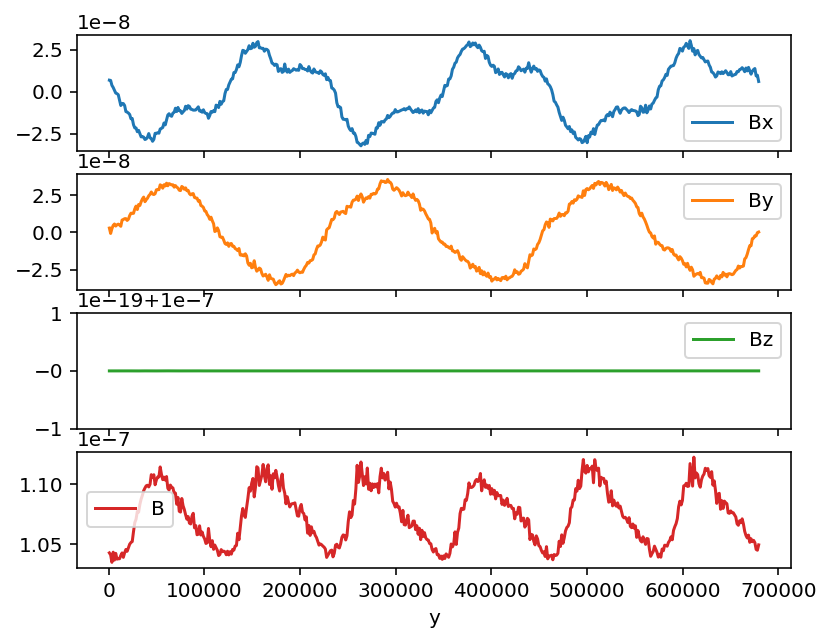

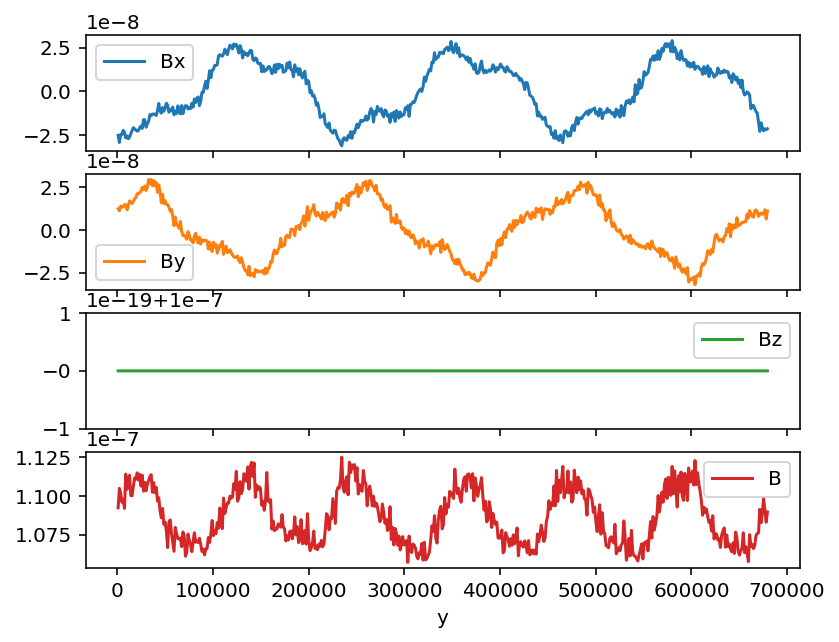

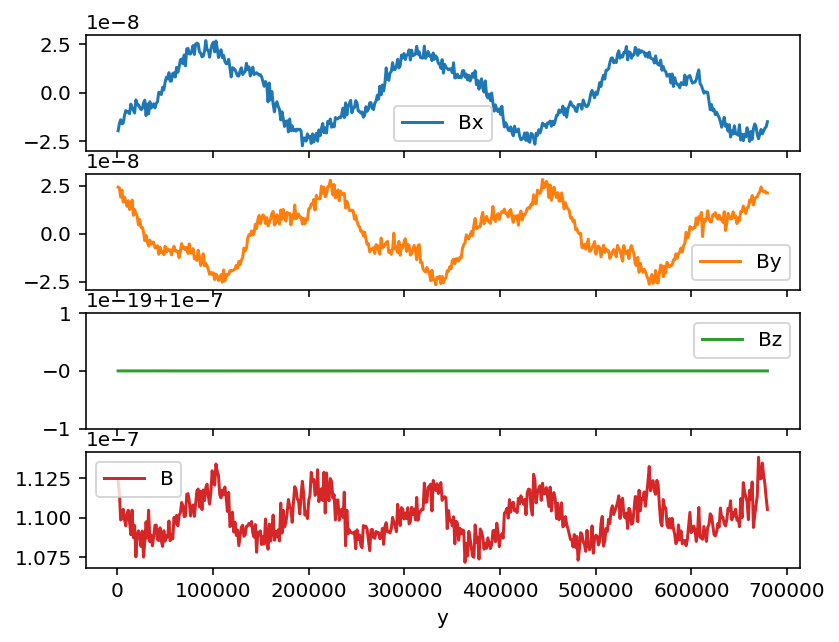

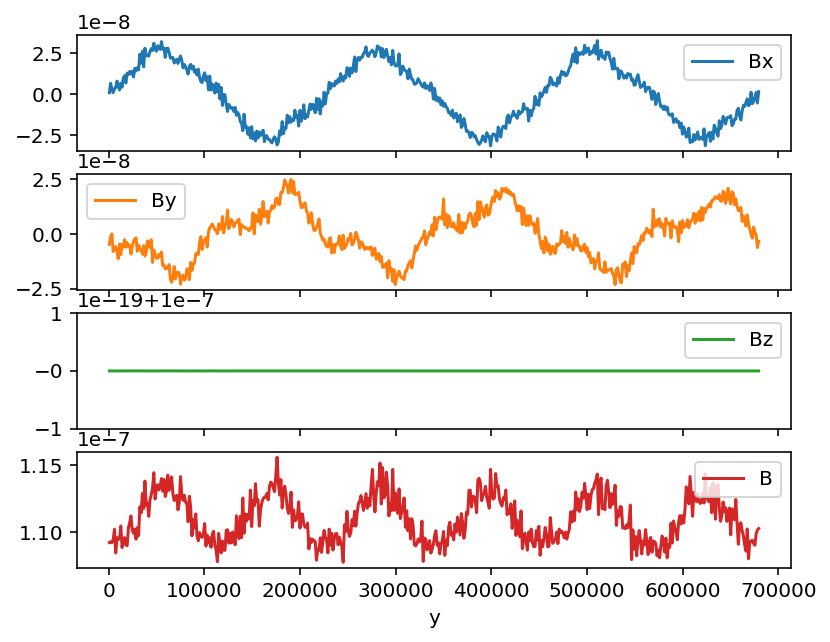

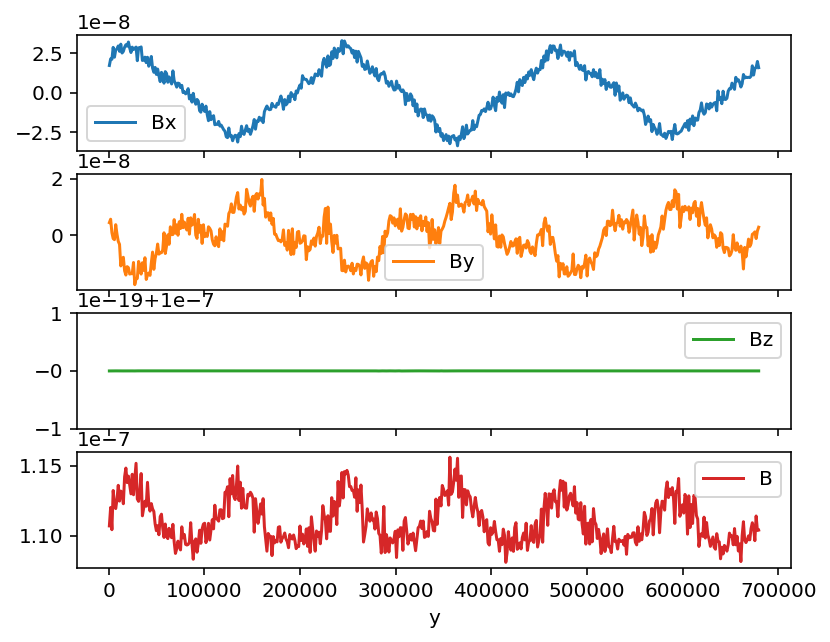

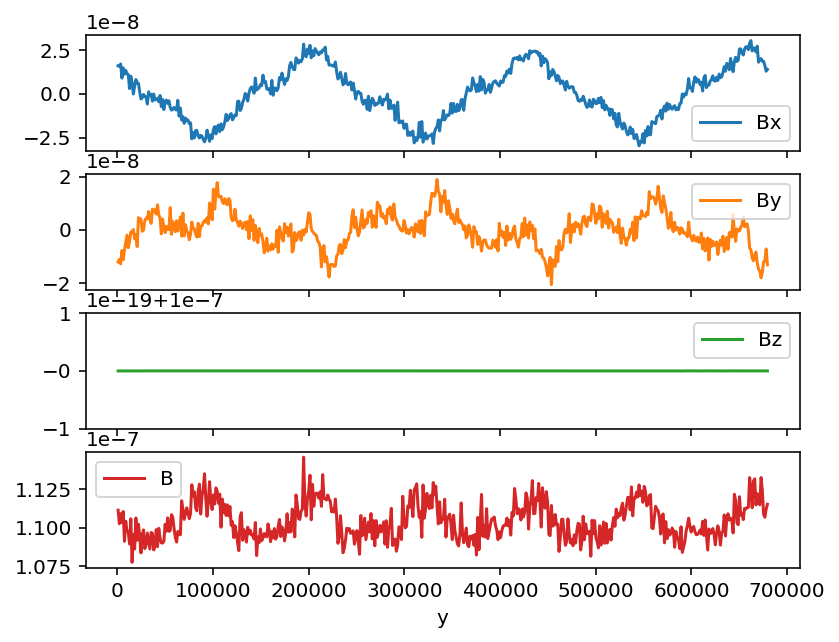

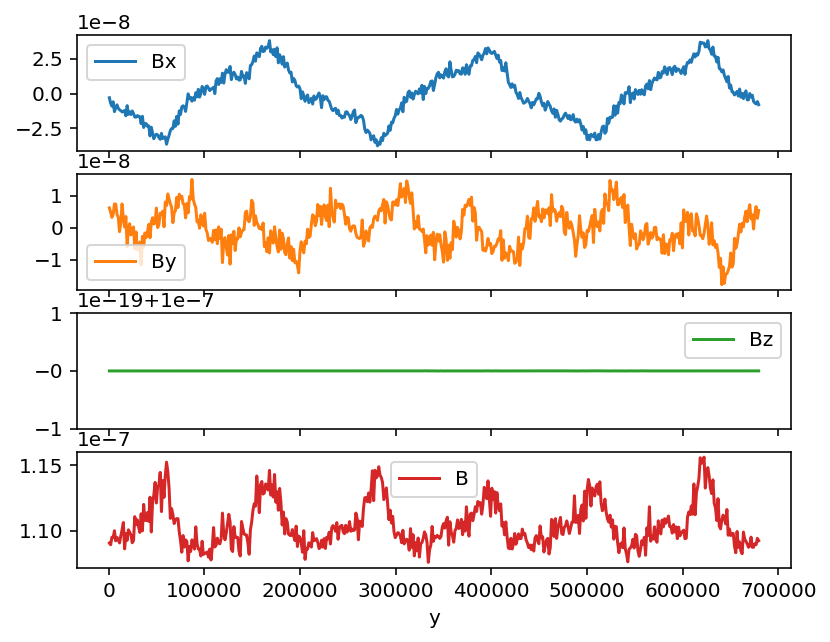

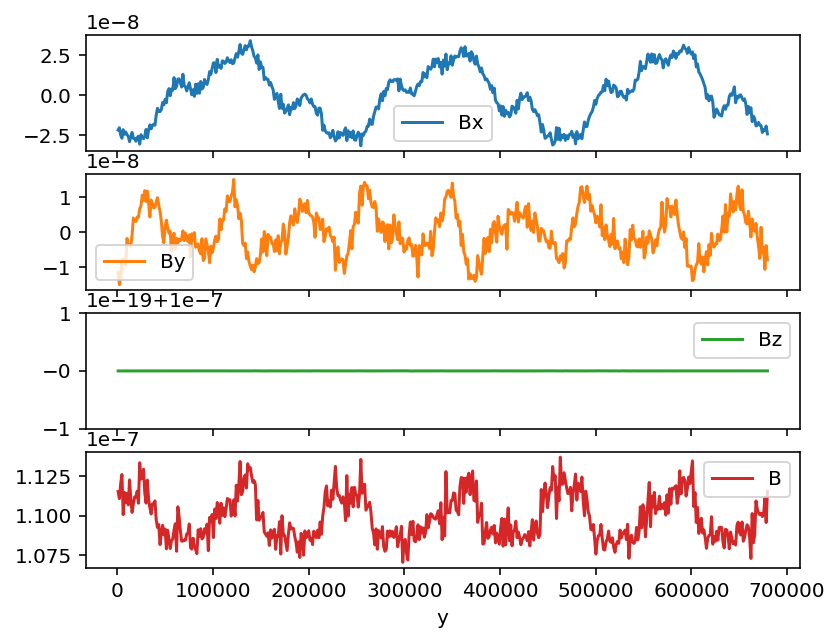

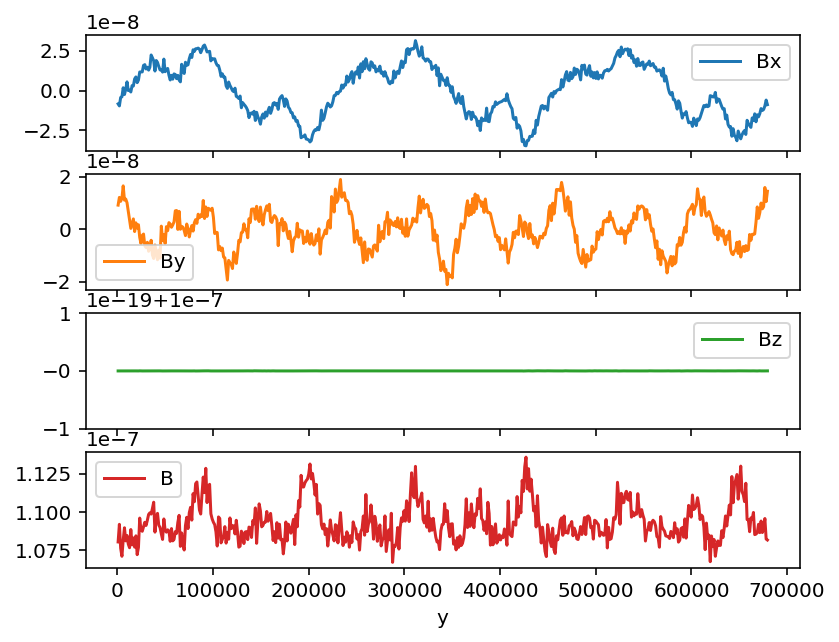

In [42]:
def plot_avg_ts(i):
    return plot_avg(ts[i])
    
time_widget = pn.widgets.IntSlider(name="Time", value=1, start=0, end=len(ts)-1)
bound_plot = pn.bind(plot_avg_ts, i=time_widget)

pn.Column(time_widget, bound_plot)

yt : [INFO     ] 2024-03-14 22:05:37,560 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-03-14 22:05:37,561 Parameters: domain_dimensions         = [256 512   1]
yt : [INFO     ] 2024-03-14 22:05:37,561 Parameters: domain_left_edge          = [-170050.98437063       0.               0.        ]
yt : [INFO     ] 2024-03-14 22:05:37,562 Parameters: domain_right_edge         = [1.70050984e+05 6.80203937e+05 1.00000000e+00]


AttributeError: 'numpy.ndarray' object has no attribute 'savefig'

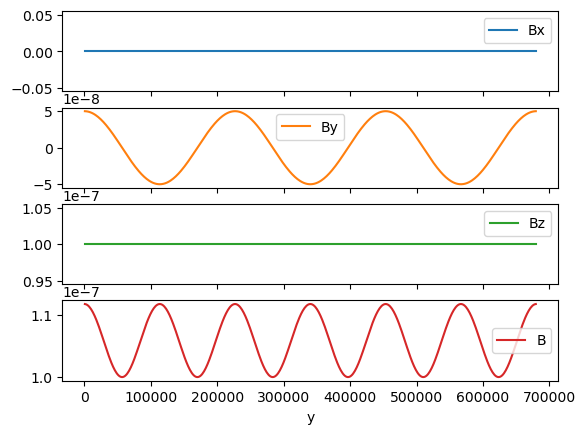

In [159]:
for ds in ts.piter():
    plot_avg(ds)

In [151]:
ds.print_stats()
print(ds.field_list)

level	# grids	       # cells	     # cells^3
----------------------------------------------
  0	   128	        131072	            51
----------------------------------------------
   	   128	        131072


t = 6.07305748e-01 code_time = 6.07305748e-01 s = 1.92443579e-08 yr

Smallest Cell:
	Width: 4.305e-20 Mpc
	Width: 4.305e-14 pc
	Width: 8.881e-09 AU
	Width: 1.329e+05 cm


[
    ('boxlib', 'Bx'),
    ('boxlib', 'By'),
    ('boxlib', 'Bz'),
    ('boxlib', 'Ex'),
    ('boxlib', 'Ey'),
    ('boxlib', 'Ez'),
    ('boxlib', 'jx'),
    ('boxlib', 'jy'),
    ('boxlib', 'jz')
]

In [ ]:
grid = ds.r[:,:,:]
obj = grid.to_xarray(fields=fields)

### OpenPMD

In [ ]:
import openpmd_api as io

# example: data handling
import numpy as np

In [ ]:
openpmd_backend = "h5"
series = io.Series(f"diags/diag1/openpmd_%06T.{openpmd_backend}", io.Access.read_only)


In [ ]:
print("openPMD version: ", series.openPMD)

In [ ]:
list(series.iterations)
i = series.iterations[64]

In [ ]:
# record
B = i.meshes["B"]

In [ ]:
# record
B = i.meshes["B"]

# record components
B_x = B["x"]
B_y = B["y"]
B_z = B["z"]

B_x_data = B_x.load_chunk()
B_y_data = B_y.load_chunk()
B_z_data = B_z.load_chunk()
series.flush()

In [ ]:
plt.plot(B_x_data)
plt.plot(B_y_data)
plt.plot(B_z_data)